## SIM Training by Stein's Method

In [1]:
import numpy as np
from matplotlib import pylab as plt

from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import make_scorer, mean_squared_error

from pysim import SimRegressor

# Case 1: Sine Ridge Function

In [2]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

The best hyperparameter combination can be selected via cross-validation

In [3]:
%%time 

param_grid = {"method": ["first_order", "second_order", "first_order_thres", "ols"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(-9, 0, 10)}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", knot_num=20, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   14.2s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:   17.3s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:   20.4s
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:   26.1s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   27.8s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 7.71 s, sys: 8.37 s, total: 16.1 s
Wall time: 28.4 s
Parser   : 185 ms


In [4]:
grid.best_params_

{'knot_dist': 'uniform',
 'method': 'first_order_thres',
 'reg_gamma': 1e-08,
 'reg_lambda': 0.1}

**NB**: The first-order Setin's method is selected, as $\mathbb{E}[f^{\prime\prime}(u)]=0$. Therefore, the second order method cannot provide any information about the projection coefficients. 

In this case, the first-order Setin's method is selected. 

In [5]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_dist='uniform', knot_num=20,
             method='first_order_thres', random_state=0, reg_gamma=1e-08,
             reg_lambda=0.1, spline='smoothing_spline')

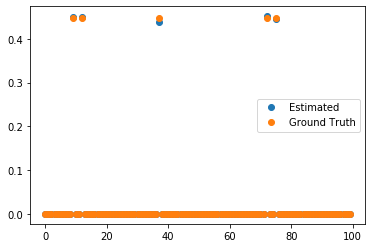

In [6]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

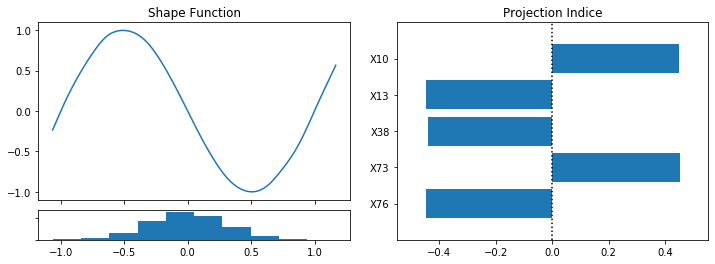

In [7]:
clf.visualize()

## Case 2: Quadratic Ridge Function

In [8]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.normal(0, 0.3, size=(n_samples, n_features))
y = np.dot(x, beta) ** 2 + 0.1 * np.random.randn(n_samples)

In [9]:
%%time

param_grid = {"method": ["first_order", "second_order", "first_order_thres", "ols"],
              "knot_dist": ["uniform", "quantile"],
              "reg_lambda": [0.1, 0.2, 0.3, 0.4, 0.5], 
              "reg_gamma": np.logspace(-9, 0, 10)}
grid = GridSearchCV(SimRegressor(spline="smoothing_spline", knot_num=20, random_state=0), iid=False,
                    cv=KFold(3, shuffle=True, random_state=0), param_grid=param_grid, n_jobs=-1, verbose=2, error_score=np.nan)
grid.fit(x, y)

Fitting 3 folds for each of 400 candidates, totalling 1200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 64 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:    1.3s
[Parallel(n_jobs=-1)]: Done 237 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 520 tasks      | elapsed:    7.2s
[Parallel(n_jobs=-1)]: Done 885 tasks      | elapsed:   13.2s
[Parallel(n_jobs=-1)]: Done 1200 out of 1200 | elapsed:   15.7s finished
/home/r7user1/anaconda2_local/envs/tf2/lib/python3.6/site-packages/sklearn/model_selection/_search.py:823: FutureWarning: The parameter 'iid' is deprecated in 0.22 and will be removed in 0.24.
  "removed in 0.24.", FutureWarning


CPU times: user 7.67 s, sys: 10.2 s, total: 17.9 s
Wall time: 16.3 s


In [10]:
grid.best_params_

{'knot_dist': 'uniform',
 'method': 'second_order',
 'reg_gamma': 1e-07,
 'reg_lambda': 0.1}

**NB**: The second-order Setin's method is selected, as $\mathbb{E}[f^{\prime}(u)]=0$. Therefore, the first order method cannot provide any information about the projection coefficients. 

In [11]:
clf = grid.best_estimator_
clf

SimRegressor(degree=2, knot_dist='uniform', knot_num=20, method='second_order',
             random_state=0, reg_gamma=1e-07, reg_lambda=0.1,
             spline='smoothing_spline')

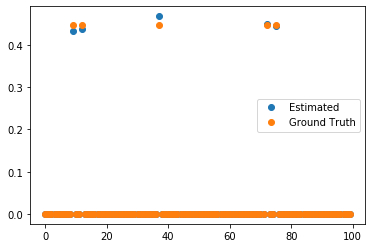

In [12]:
plt.plot(np.abs(clf.beta_), "o")
plt.plot(np.abs(beta), "o")
plt.legend(["Estimated", "Ground Truth"])
plt.show()

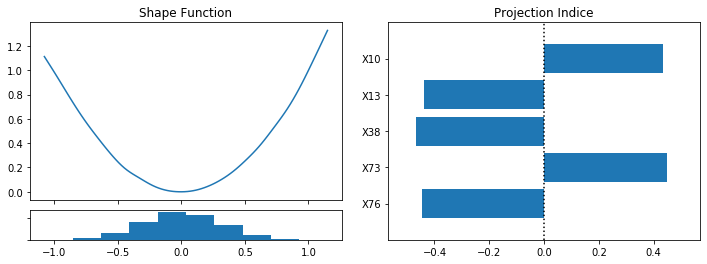

In [13]:
clf.visualize()

## Case 3: Improve a rough estimator via inner update

In [14]:
s_star = 5
n_features = 100
n_samples = 10000

np.random.seed(1)
beta = np.zeros(n_features)
supp_ids = np.random.choice(n_features, s_star)
beta[supp_ids]=np.random.choice((-1, 1), s_star) / np.sqrt(s_star)

x = np.random.gamma(1, 0.3, size=(n_samples, n_features))
y = np.sin(np.pi*(np.dot(x, beta))) + 0.1 * np.random.randn(n_samples)

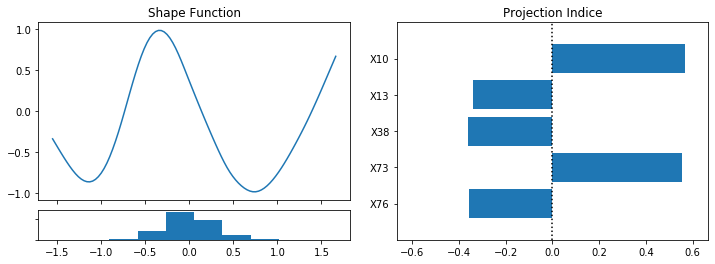

CPU times: user 3.67 s, sys: 6.68 s, total: 10.4 s
Wall time: 900 ms


In [15]:
%%time

clf = SimRegressor(degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=10**(-7), spline="smoothing_spline", random_state=0)
clf.fit(x, y)
clf.visualize()

**Remark**：The data does not follow a normal distribution, so the performance is relatively poorer, we use adam optimizer to improve the estimation.

To improve the solution, we provide two options for inner update: **adam optimizer** and **BFGS optimizer**.

Inner iter: 1 epoch: 1 with validation loss: 0.02702
Inner iter: 1 epoch: 2 with validation loss: 0.02461
Inner iter: 1 epoch: 3 with validation loss: 0.02286
Inner iter: 1 epoch: 4 with validation loss: 0.02153
Inner iter: 1 epoch: 5 with validation loss: 0.02052
Inner iter: 1 epoch: 6 with validation loss: 0.01961
Inner iter: 1 epoch: 7 with validation loss: 0.01887
Inner iter: 1 epoch: 8 with validation loss: 0.01839
Inner iter: 1 epoch: 9 with validation loss: 0.01804
Inner iter: 1 epoch: 10 with validation loss: 0.01785
Inner iter: 1 epoch: 11 with validation loss: 0.01771
Inner iter: 1 epoch: 12 with validation loss: 0.01747
Inner iter: 1 epoch: 13 with validation loss: 0.01742
Inner iter: 1 epoch: 14 with validation loss: 0.01737
Inner iter: 1 epoch: 15 with validation loss: 0.01728
Inner iter: 2 epoch: 1 with validation loss: 0.01174
Inner iter: 2 epoch: 2 with validation loss: 0.01143
Inner iter: 2 epoch: 3 with validation loss: 0.01119
Inner iter: 2 epoch: 4 with validation l

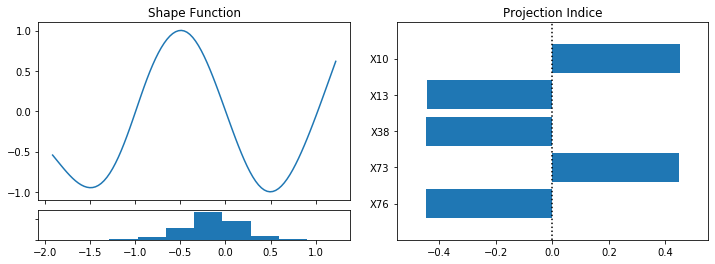

In [16]:
clf = SimRegressor(degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=10**(-7), spline="smoothing_spline", random_state=0)
clf.fit(x, y)
clf.fit_inner_update(x, y, method="adam", n_inner_iter_no_change=1, n_epoch_no_change=3, batch_size=1000, verbose=True)
clf.visualize()

Inner iter: 1 with validation loss: 0.01143
Inner iter: 2 with validation loss: 0.01022
Inner iter: 3 with validation loss: 0.01014


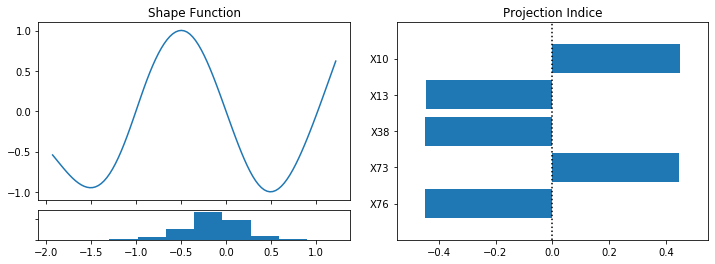

In [17]:
clf = SimRegressor(degree=2, knot_num=20, reg_lambda=0.1, reg_gamma=10**(-7), spline="smoothing_spline", random_state=0)
clf.fit(x, y)
clf.fit_inner_update(x, y, method="bfgs", n_inner_iter_no_change=1, verbose=True)
clf.visualize()

**Remark**: fit_inner_update is not available for spline="p_spline" or "mono_p_spline"